# Imports

In [2]:
# general
import pandas as pd
import numpy as np
import errno
import json
import os
import cv2

# modeling
from keras.models import Sequential, model_from_json
from keras.layers import Dense, Dropout, Activation, Flatten, SpatialDropout2D, ELU
from keras.layers import Convolution2D, MaxPooling2D, Cropping2D
from keras.layers.core import Lambda
from keras.optimizers import SGD, Adam, RMSprop
from keras.utils import np_utils, plot_model
from keras.callbacks import ModelCheckpoint
from keras.utils import vis_utils

# science
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import scipy.misc
from scipy.ndimage import rotate
from scipy.stats import bernoulli

# plotting
from IPython.display import SVG
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

Using TensorFlow backend.


# Data

In [3]:
# Some useful constants
logfile = '../data/simulator/driving_log.csv'
imgfiles = '../data/simulator/'
scoeff = 0.229

In [9]:
df = pd.read_csv(logfile)
df.head()

,center,left,right,steering,throttle,brake,speed
0,IMG/center_2016_12_01_13_30_48_287.jpg,IMG/left_2016_12_01_13_30_48_287.jpg,IMG/right_2016_12_01_13_30_48_287.jpg,0.0,0.0,0.0,22.148290
1,IMG/center_2016_12_01_13_30_48_404.jpg,IMG/left_2016_12_01_13_30_48_404.jpg,IMG/right_2016_12_01_13_30_48_404.jpg,0.0,0.0,0.0,21.879630
2,IMG/center_2016_12_01_13_31_12_937.jpg,IMG/left_2016_12_01_13_31_12_937.jpg,IMG/right_2016_12_01_13_31_12_937.jpg,0.0,0.0,0.0,1.453011
3,IMG/center_2016_12_01_13_31_13_037.jpg,IMG/left_2016_12_01_13_31_13_037.jpg,IMG/right_2016_12_01_13_31_13_037.jpg,0.0,0.0,0.0,1.438419
4,IMG/center_2016_12_01_13_31_13_177.jpg,IMG/left_2016_12_01_13_31_13_177.jpg,IMG/right_2016_12_01_13_31_13_177.jpg,0.0,0.0,0.0,1.418236


In [18]:
df2 = df.copy()

In [21]:
df2.drop(['center', 'left', 'right'], axis=1, inplace=True)

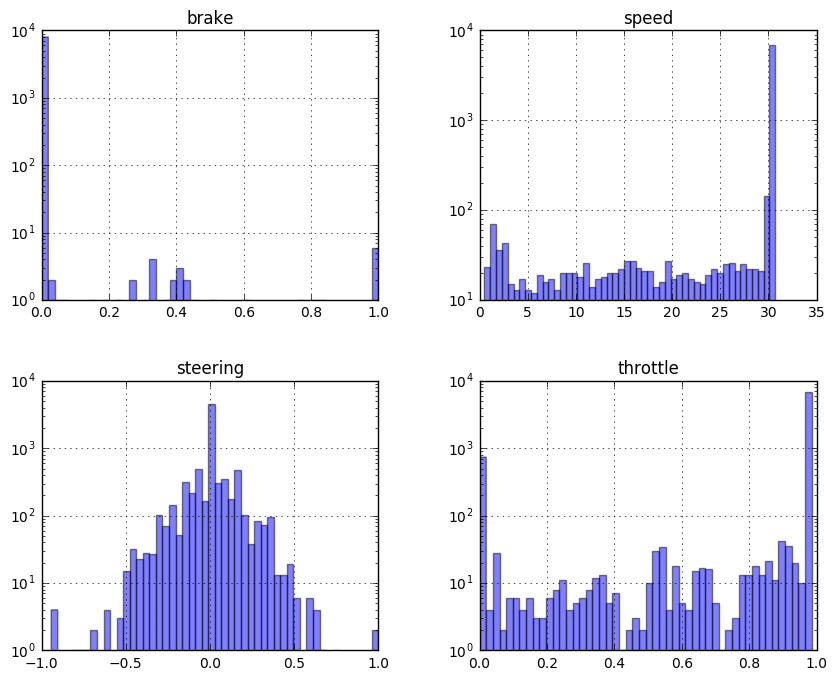

In [33]:
df2.hist(alpha=0.5, bins=50, figsize=(10,8), log=True);

Steering angle range is too narrow and needs to be augmented. The simplest route to this is to create a wide variety of random distortions of the training data. See this below.

# Augment

In [3]:
def crop(image, ceiling, floor):
    assert 0 <= ceiling < 0.5, 'invalid ceiling; 0.0-0.5 but used {}'.format(ceiling)
    assert 0 <= floor < 0.5, 'invalid floor; 0.0-0.5 but used {}'.format(floor)
    top = int(np.ceil(image.shape[0] * ceiling))
    bottom = image.shape[0] - int(np.ceil(image.shape[0] * floor))
    return image[top:bottom, :]

In [4]:
def resize(img, new_dim):
    return scipy.misc.imresize(img, new_dim)

In [5]:
def randflip(img, steering_angle, flipping_prob=0.5):
    head = bernoulli.rvs(flipping_prob)
    if head:
        return np.fliplr(img), -1 * steering_angle
    else:
        return img, steering_angle

In [6]:
def randgamma(img):
    gamma = np.random.uniform(0.4, 1.5)
    inv_gamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** inv_gamma) * 255
                      for i in np.arange(0, 256)]).astype("uint8")
    return cv2.LUT(img, table)

In [7]:
def randshear(img, steering_angle, shear_range=200):
    rows, cols, ch = img.shape
    dx = np.random.randint(-shear_range, shear_range + 1)
    randpoint = [cols / 2 + dx, rows / 2]
    pts1 = np.float32([[0, rows], [cols, rows], [cols / 2, rows / 2]])
    pts2 = np.float32([[0, rows], [cols, rows], randpoint])
    dsteering = dx / (rows / 2) * 360 / (2 * np.pi * 25.0) / 6.0
    M = cv2.getAffineTransform(pts1, pts2)
    img = cv2.warpAffine(img, M, (cols, rows), borderMode=1)
    steering_angle += dsteering
    return img, steering_angle

In [8]:
def randrotation(img, steering_angle, rotation_amount=15):
    angle = np.random.uniform(-rotation_amount, rotation_amount + 1)
    rad = (np.pi / 180.0) * angle
    return rotate(img, angle, reshape=False), steering_angle + (-1) * rad

In [9]:
def min_max(data, a=-0.5, b=0.5):
    data_max = np.max(data)
    data_min = np.min(data)
    return a + (b - a) * ((data - data_min) / (data_max - data_min))

In [10]:
def gen_new_image(img, steering_angle, top_crop_percent=0.35, bottom_crop_percent=0.1,
                       resize_dim=(64, 64), do_shear_prob=0.9):
    head = bernoulli.rvs(do_shear_prob)
    if head == 1:
        img, steering_angle = randshear(img, steering_angle)
    img = crop(img, top_crop_percent, bottom_crop_percent)
    img, steering_angle = randflip(img, steering_angle)
    img = randgamma(img)
    img = resize(img, resize_dim)
    return img, steering_angle

In [11]:
def get_next_image(batch_size=64):
    data = pd.read_csv(logfile)
    num_of_img = len(data)
    rnd_indices = np.random.randint(0, num_of_img, batch_size)

    image_files_and_angles = []
    for index in rnd_indices:
        rnd_image = np.random.randint(0, 3)
        if rnd_image == 0:
            img = data.iloc[index]['left'].strip()
            angle = data.iloc[index]['steering'] + scoeff
            image_files_and_angles.append((img, angle))

        elif rnd_image == 1:
            img = data.iloc[index]['center'].strip()
            angle = data.iloc[index]['steering']
            image_files_and_angles.append((img, angle))
        else:
            img = data.iloc[index]['right'].strip()
            angle = data.iloc[index]['steering'] - scoeff
            image_files_and_angles.append((img, angle))
    return image_files_and_angles

In [12]:
def gen_next_batch(batch_size=64):
    while True:
        X_batch = []
        y_batch = []
        images = get_next_image(batch_size)
        for img_file, angle in images:
            raw_image = plt.imread(imgfiles + img_file)
            raw_angle = angle
            new_image, new_angle = gen_new_image(raw_image, raw_angle)
            X_batch.append(new_image)
            y_batch.append(new_angle)
        assert len(X_batch) == batch_size, 'require len(X_batch) == batch_size.'
        yield np.array(X_batch), np.array(y_batch)

In [13]:
def save_model(model, model_name='model.json', weights_name='model.h5'):
    try:
        os.remove(model_name)
        os.remove(weights_name)
    except OSError as error:
        if error.errno != errno.ENOENT:
            raise
    json_string = model.to_json()
    with open(model_name, 'w') as outfile:
        json.dump(json_string, outfile)
    model.save_weights(weights_name)

# Model

In [14]:
# nvidia model
# https://images.nvidia.com/content/tegra/automotive/images/2016/solutions/pdf/end-to-end-dl-using-px.pdf

model = Sequential()

model.add(Lambda(lambda x: x / 127.5 - 1.0, input_shape=(64, 64, 3)))

# five conv and pooling
model.add(Convolution2D(24, 5, 5, border_mode='same', subsample=(2, 2)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(1, 1)))

model.add(Convolution2D(36, 5, 5, border_mode='same', subsample=(2, 2)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(1, 1)))

model.add(Convolution2D(48, 5, 5, border_mode='same', subsample=(2, 2)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(1, 1)))

model.add(Convolution2D(64, 3, 3, border_mode='same', subsample=(1, 1)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(1, 1)))

model.add(Convolution2D(64, 3, 3, border_mode='same', subsample=(1, 1)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(1, 1)))

model.add(Flatten())

# five fully connected
model.add(Dense(1164))
model.add(Activation('relu'))

model.add(Dense(100))
model.add(Activation('relu'))

model.add(Dense(50))
model.add(Activation('relu'))

model.add(Dense(10))
model.add(Activation('relu'))

model.add(Dense(1))

model.summary()

learning_rate = 1e-4
model.compile(optimizer=Adam(learning_rate), loss="mse", )

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_1 (Lambda)            (None, 64, 64, 3)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 24)        1824      
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 24)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 31, 31, 24)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 36)        21636     
_________________________________________________________________
activation_2 (Activation)    (None, 16, 16, 36)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 15, 15, 36)        0         
__________

/opt/conda/lib/python3.5/site-packages/ipykernel/__main__.py:9: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(24, (5, 5), strides=(2, 2), padding="same")`
/opt/conda/lib/python3.5/site-packages/ipykernel/__main__.py:13: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(36, (5, 5), strides=(2, 2), padding="same")`
/opt/conda/lib/python3.5/site-packages/ipykernel/__main__.py:17: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(48, (5, 5), strides=(2, 2), padding="same")`
/opt/conda/lib/python3.5/site-packages/ipykernel/__main__.py:21: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), strides=(1, 1), padding="same")`
/opt/conda/lib/python3.5/site-packages/ipykernel/__main__.py:25: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), strides=(1, 1), padding="same")`


In [ ]:
# visualize
plot_model(model, to_file='model.png')
#SVG(vis_utils.model_to_dot(model).create(prog='dot', format='svg'))

# Training

In [ ]:
# hyperparams
number_of_epochs = 20
number_of_samples_per_epoch = 20000
number_of_validation_samples = 0.2*number_of_samples_per_epoch

# create two generators for training and validation
train_gen = gen_next_batch()
validation_gen = gen_next_batch()
checkpointer = ModelCheckpoint(filepath="/tmp/behclone.{epoch:02d}-{val_loss:.2f}.hdf5",
                               verbose=1,
                               save_best_only=False)
history = model.fit_generator(train_gen,
                              samples_per_epoch=number_of_samples_per_epoch,
                              nb_epoch=number_of_epochs,
                              validation_data=validation_gen,
                              nb_val_samples=number_of_validation_samples,
                              callbacks=[checkpointer],
                              verbose=1)

In [ ]:
print("Saving model...")
save_model(model)
print("Model saved.")
print("Done")

In [34]:
!jupyter nbconvert --to script p3-behavioral-cloning.ipynb

[NbConvertApp] Converting notebook p3-behavioral-cloning.ipynb to script
[NbConvertApp] Writing 8413 bytes to p3-behavioral-cloning.py


In [ ]:
!python video.py ../data/simulator/IMG
!mv ../data/simulator/IMG.mp4 movie.mp4